In [2]:
import jax
import numpy as np
import optax
from einops import rearrange
from jax import jit
from jax import numpy as jnp
from jax import random as jrnd
from jaxtyping import Array, Float, PRNGKeyArray
from matplotlib import dates
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

jax.config.update("jax_enable_x64", True)

## Training a Neural ODE on the Covid SIR-Model

Loading the data:

In [3]:
data = jnp.load("data_info.npz")
S = data["sird_data"][:, 0] / 1000
I = data["sird_data"][:, 1] / 1000
R = (data["sird_data"][:, 2] + data["sird_data"][:, 3]) / 1000

data_grid = jnp.array(data["data_grid"], dtype=int)
# print(data["date_range_x"].shape)
data_dates = data["date_range_x"][data_grid]

# Use this Kalman Filter
I_data = I[data_grid]
n = len(I_data)
date_mean = jnp.mean(data_grid)
date_span = jnp.ptp(data_grid)
I_mean = jnp.mean(I_data)
I_span = jnp.ptp(I_data)


def t_center(x: Float[Array, "n"]) -> Float[Array, "n"]:
    """Center the data."""
    return (x - date_mean) / date_span 


def t_decenter(x: Float[Array, "n"]) -> Float[Array, "n"]:
    """Decenter the data."""
    return x * date_span + date_mean 


def I_center(I: Float[Array, "n"]) -> Float[Array, "n"]:
    """Center the data."""
    return (I - I_mean) / I_span


def I_decenter(I: Float[Array, "n"]) -> Float[Array, "n"]:
    """Decenter the data."""
    return I * I_span + I_mean


# I_data

In [4]:
import diffrax
import equinox as eqx
from diffrax import Dopri5, ODETerm, SaveAt, Tsit5, diffeqsolve

In [5]:
@jit
def f_SIR(t, y, args):
    S = y[0]
    I = y[1]
    R = y[2]
    beta = args["beta"]
    gamma = args["gamma"]
    return jnp.asarray([-beta * S * I, beta(t) * S * I - gamma * I, gamma * I])

a Model for $\beta(t)$:

In [6]:
class forced_SIR(eqx.Module):
    beta: eqx.nn.MLP

    def __init__(self, width: int, depth: int, key: PRNGKeyArray):
        self.beta = eqx.nn.MLP(
            in_size="scalar",
            out_size="scalar",
            width_size=width,
            depth=depth,
            key=key,
            activation=jax.nn.selu,
            final_activation=jax.nn.sigmoid,
        )

    def __call__(self, t, y, args):
        beta = self.beta(t_center(t))
        gamma = args["gamma"]
        S = y[0]
        I = y[1]
        R = y[2]
        return jnp.asarray([-beta * S * I, beta * S * I - gamma * I, gamma * I])


class NeuralODE(eqx.Module):
    func: forced_SIR

    def __init__(self, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = forced_SIR(width=width_size, depth=depth, key=key)

    def __call__(self, ts):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Dopri5(),
            t0=data_grid[0],
            t1=data_grid[-1],
            dt0=data_grid[1] - data_grid[0],
            args={"gamma": .1},
            y0=jnp.array([1 - I_data[0], I_data[0], 0.0]),
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

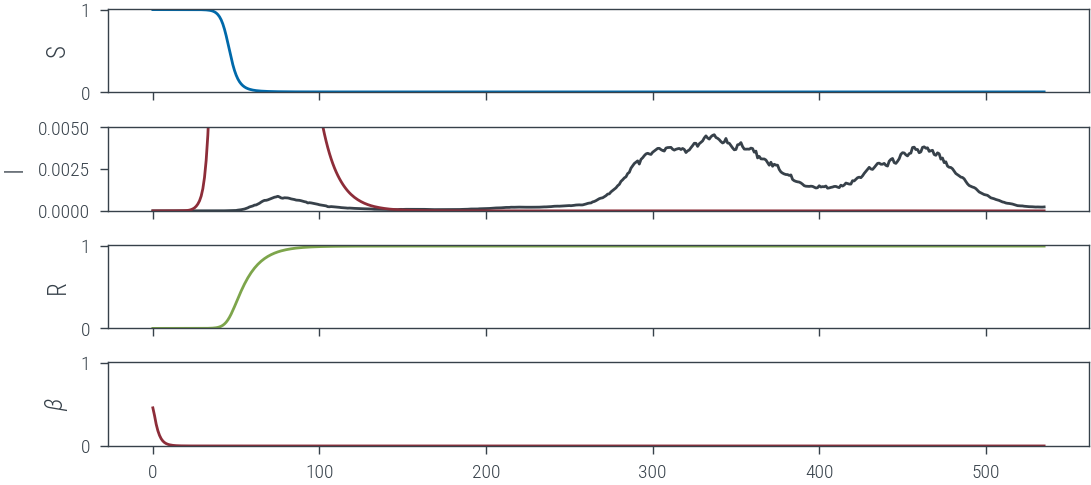

In [7]:
KEY = jrnd.PRNGKey(0)
model = NeuralODE(width_size=64, depth=2, key=KEY)

fig, ax = plt.subplots(4,1, sharex=True)
pred = model(data_grid)
ax[0].plot(data_grid, pred[:,0], label="Initial prediction", color=rgb.tue_blue)
ax[0].set_ylabel("S")
ax[0].set_ylim(0, 1.01)

ax[1].plot(data_grid, I_data, label="Initial prediction", color=rgb.tue_dark)
ax[1].plot(data_grid, pred[:,1], label="Initial prediction", color=rgb.tue_red)
ax[1].set_ylabel("I")
ax[1].set_ylim(0, 0.005)

ax[2].plot(data_grid, pred[:,2], label="Initial prediction", color=rgb.tue_green)
ax[2].set_ylabel("R")
ax[2].set_ylim(0, 1.01)

ax[3].plot(data_grid, jax.vmap(model.func.beta)(data_grid), label="Initial beta", color=rgb.tue_red)
ax[3].set_ylabel(r"$\beta$")
ax[3].set_ylim(0, 1.01);


In [8]:
from torch.utils.data import DataLoader, Dataset
import numpy as np

# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class SIRDataset(Dataset):
    def __init__(self, data_grid, I_data):
        self.t = data_grid
        self.Y = I_data

    def __len__(self):
        return len(self.t)

    def __getitem__(self, idx):
        return self.t[idx], self.Y[idx] 
    
train_dataset = SIRDataset(data_grid, I_data)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=numpy_collate)

data_in, data_out = next(iter(train_loader))

Train

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0, Loss: 7969067.4544
Epoch 10, Loss: 14839107.9854
Epoch 20, Loss: 4084996.5464
Epoch 30, Loss: 1357273.4823
Epoch 40, Loss: 596632.3219
Epoch 50, Loss: 2568.2626
Epoch 60, Loss: 2037.4507
Epoch 70, Loss: 2892.8693
Epoch 80, Loss: 2198.2314
Epoch 90, Loss: 883.9443
Epoch 100, Loss: 1427.5582
Epoch 110, Loss: 2083.2828
Epoch 120, Loss: 715.6674
Epoch 130, Loss: 1805.4843
Epoch 140, Loss: 1638.8298
Epoch 150, Loss: 1731.8111
Epoch 160, Loss: 1285.8060
Epoch 170, Loss: 2455.2782
Epoch 180, Loss: 703.9840
Epoch 190, Loss: 802.0025
Epoch 200, Loss: 1623.5952
Epoch 210, Loss: 1537.8799
Epoch 220, Loss: 1566.2255
Epoch 230, Loss: 885.4098
Epoch 240, Loss: 960.6350
Epoch 250, Loss: 1502.2097
Epoch 260, Loss: 1814.3439
Epoch 270, Loss: 1745.7144
Epoch 280, Loss: 1145.8481
Epoch 290, Loss: 1217.2034
Epoch 300, Loss: 1379.7102
Epoch 310, Loss: 1519.2903
Epoch 320, Loss: 688.2770
Epoch 330, Loss: 699.5577
Epoch 340, Loss: 1066.8887
Epoch 350, Loss: 773.7251
Epoch 360, Loss: 783.8974
Epoch 3

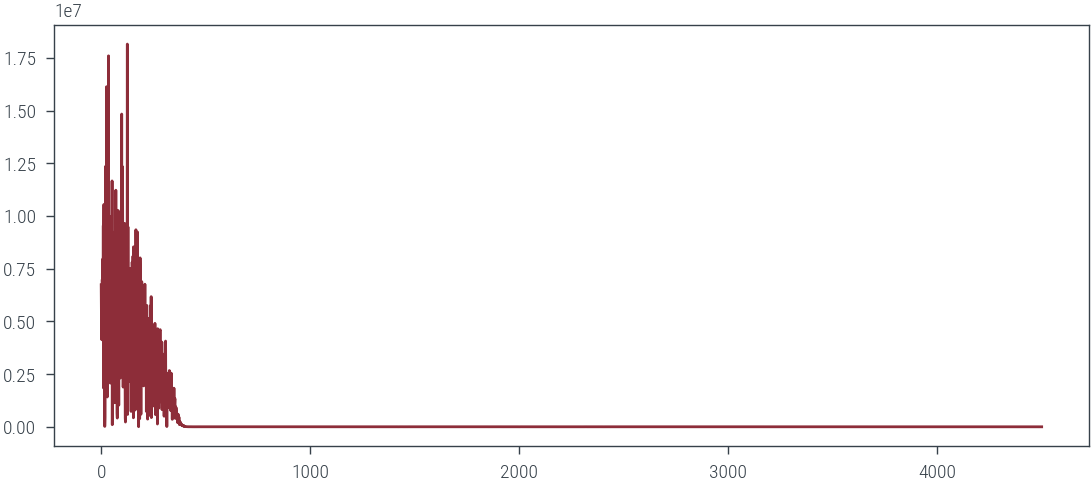

In [9]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    inds = jnp.argsort(ti)
    ti = ti[inds]
    yi = yi[inds]
    y_pred = model(ti)[:, 1]
    return jnp.mean((yi - y_pred) ** 2) * 1e9


@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


optim = optax.adam(learning_rate=1e-4)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

losses = []

for epoch in tqdm(range(500)):
    for ti, yi in train_loader:
        # inds = jnp.argsort(ti)
        # ti = ti[inds]
        # yi = yi[inds]
        # y_pred = model(ti)[:, 1]
        # print(f"{yi=}\n{y_pred=}")

        loss, model, opt_state = make_step(ti, yi, model, opt_state)
        losses.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

plt.plot(losses, label="Loss")

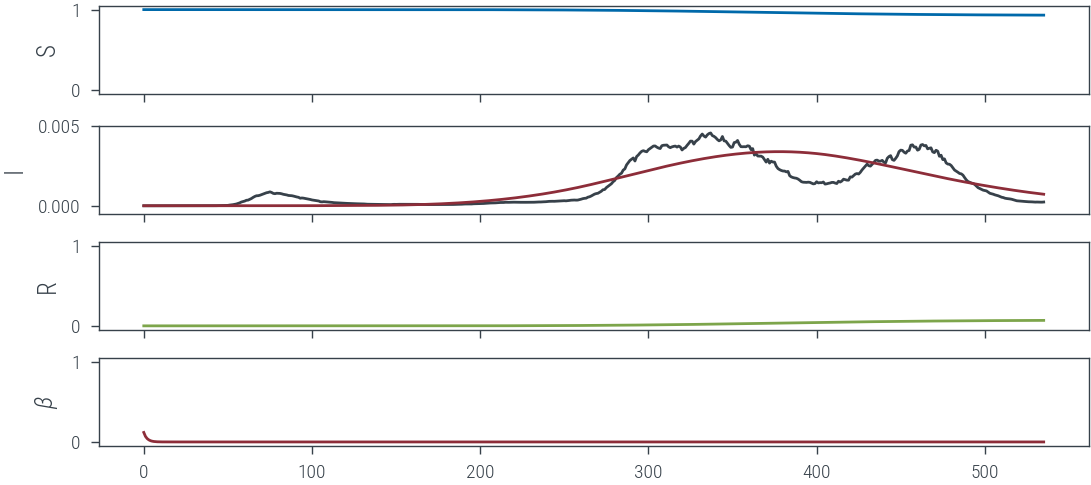

In [10]:
fig, ax = plt.subplots(4,1, sharex=True)
pred = model(data_grid)
ax[0].plot(data_grid, pred[:,0], label="Initial prediction", color=rgb.tue_blue)
ax[0].set_ylabel("S")
ax[0].set_ylim(-0.05, 1.05)

ax[1].plot(data_grid, I_data, label="Initial prediction", color=rgb.tue_dark)
ax[1].plot(data_grid, pred[:,1], label="Initial prediction", color=rgb.tue_red)
ax[1].set_ylabel("I")
ax[1].set_ylim(-0.0005, 0.005)

ax[2].plot(data_grid, pred[:,2], label="Initial prediction", color=rgb.tue_green)
ax[2].set_ylabel("R")
ax[2].set_ylim(-0.05, 1.05)

ax[3].plot(data_grid, jax.vmap(model.func.beta)(data_grid), label="Initial beta", color=rgb.tue_red)
ax[3].set_ylabel(r"$\beta$")
ax[3].set_ylim(-0.05, 1.05);

# plt.savefig("sird_neural_ode.pdf")